In [1]:
%matplotlib inline 
import pickle
import os
import numpy as np
import json
from PIL import Image,ImageDraw
import sys

import cv2
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import find_contours

from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box

In [2]:
from random import sample

In [3]:
imagePath = r'C:\Users\jiali\Desktop\choroColorRead\generatedMaps\quantiles'
imageName = 'ohio_Blues_4_pos_small1.jpg'
# testImages = os.listdir(imagePath)

In [4]:
# read detection results from pickle file
detectResultsPath = r'D:\OneDrive - The Ohio State University\choroColorRead'
detectResultFileName = 'detectResultSpatialPattern.pickle'
with open(detectResultsPath + '\\' + detectResultFileName, 'rb') as f:
    detectResults = pickle.load(f)

In [5]:
detectResult = detectResults[6]

In [6]:
property = detectResult[1]
boxes = property['rois']
masks = property['masks']
class_ids = property['class_ids']

# extract mask for mapping area
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

image = cv2.imread(imagePath + '\\' + imageName)
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

masked_image = image.astype(np.uint32).copy()
maskPolyList = []

In [7]:
image.shape

(966, 1576, 3)

In [8]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

966
1576


In [9]:
# get the polygon for mapping area
for i in range(N):
#     if i > 0:
#         continue
    if class_ids[i] != 3:
        continue
    # Bounding box
    if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue
    y1, x1, y2, x2 = boxes[i]
    bboxMap = box(x1, y1, x2, y2)
    # Mask
    mask = masks[:, :, i]

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        vertList = [(vert[0],vert[1]) for vert in verts]
        maskPolygon = Polygon(vertList)
        maskPolyList.append(maskPolygon)

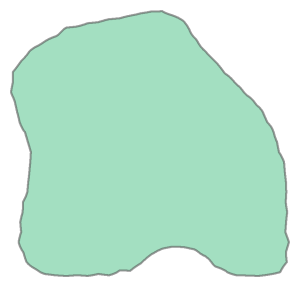

In [10]:
maskPolygon

In [11]:
# rgb color list
colorList = [[191, 214, 230], [107, 174, 216], [33, 114, 180], [239, 243, 255]]

In [12]:
def bgr2rgb(value):
    return value[2],value[0],value[1]
def valueEqualColor(value,color):
    colorR, colorG, colorB = color[0], color[1], color[2]
    valueR, valueG, valueB = value[0], value[1], value[2]
    if abs(colorR - valueR) > 10 or abs(colorB - valueB) > 10 or abs(colorG - valueG) > 10:
        return False
    else:
        return True

In [13]:
def rgb2Grey(dominantColor):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    dominantColorGrey = int(np.dot(dominantColor, rgb_weights))
    return dominantColorGrey

In [14]:
# traverse the whole image
colorGrey0 = rgb2Grey(colorList[0])
colorGrey1 = rgb2Grey(colorList[1])
colorGrey2 = rgb2Grey(colorList[2])
colorGrey3 = rgb2Grey(colorList[3])

In [15]:
pixelCoordList0, pixelCoordList1, pixelCoordList2, pixelCoordList3 = [],[],[],[]
for i in range(height):
    if i % 100 == 0:
        print(i)
    for j in range(mask.shape[1]):
        # test x,y axis
#         if i != 148 or j != 257:
#             continue
        point = Point(j,i)
#         if bboxMap.contains(point) and maskPolygon.contains(point):
        if mask[i,j] == True:
#             print('yes!')
            value =  imageGray[i,j]
#             print(value)
            b, g, r = image[i,j]
#             value_rgb = value
#             print(value_rgb)
            if not (abs(b - g) < 10 and abs(b-r) < 10 and abs(g - r)<10):
                if abs(value - colorGrey0) <= 10:
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList0.append((j,i))  
                elif abs(value - colorGrey1) <= 10:
#                     print('1: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList1.append((j,i))  
                elif abs(value - colorGrey2) <= 10:
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList2.append((j,i))  
                elif abs(value - colorGrey3) <= 10:
#                     print('0: j: '+ str(j) + ' i: ' + str(i))
                    pixelCoordList3.append((j,i))  

0
100


C:\Users\jiali\anaconda3\envs\imageProcess\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ubyte_scalars


200
300
400
500
600
700
800
900


In [16]:
pixelCoordList0_sample = sample(pixelCoordList0,int(len(pixelCoordList0)/100))
pixelCoordList1_sample = sample(pixelCoordList1,int(len(pixelCoordList1)/100))
pixelCoordList2_sample = sample(pixelCoordList2,int(len(pixelCoordList2)/100))
pixelCoordList3_sample = sample(pixelCoordList3,int(len(pixelCoordList3)/100))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

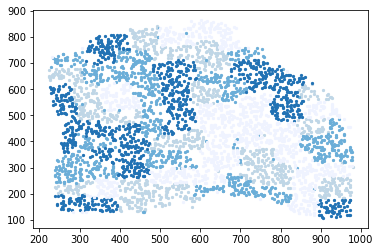

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in pixelCoordList0_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList0_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[0])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList1_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList1_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[1])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList2_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList2_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[2])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList3_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList3_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[3])/255.0)
plt.show()

In [18]:
import math

In [19]:
from sklearn.neighbors import KDTree

In [20]:
def distance(coord1, coord2):
    x1, y1 = coord1[0], coord1[1]
    x2, y2 = coord2[0], coord2[1]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [21]:
classHighestValues = pixelCoordList2_sample # the third color is with the largest value
numPoints = len(classHighestValues)
X = np.array([[coord[0],coord[1]] for coord in classHighestValues])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
queryResults = kdt.query(X, k=2, return_distance=True)
queryResults20 = kdt.query(X, k=200, return_distance=True)
queryResultsAll = kdt.query(X, k=numPoints, return_distance=True)
distanceArray = queryResults[0]
distanceArray20 = queryResults20[0]
distanceArrayAll = queryResultsAll[0]
distanceArray

array([[0.        , 3.        ],
       [0.        , 2.        ],
       [0.        , 3.60555128],
       ...,
       [0.        , 5.83095189],
       [0.        , 2.23606798],
       [0.        , 6.32455532]])

In [22]:
distanceList20 = distanceArray20.tolist()
distanceList20 = [sum(distance20[1:200])/199 for distance20 in distanceList20]
distanceList20

[76.9486818290431,
 74.29907075574289,
 98.277990767936,
 83.28819177800074,
 63.857159792720736,
 90.87244479551028,
 74.58576369272795,
 67.26144286236503,
 75.2464855029867,
 114.1695469944122,
 70.52949283531001,
 61.79430283887734,
 142.41913087360322,
 143.89191856732856,
 90.44217349442191,
 116.62457119342415,
 121.24969932877076,
 88.17111345601732,
 64.62912956424084,
 101.70694808372804,
 63.87346071869354,
 120.33089412671823,
 68.11167765224164,
 69.79985630989887,
 79.76430012768293,
 78.52703528437027,
 145.0071240429876,
 89.53599618009825,
 100.69886144443636,
 81.52238290625436,
 100.81370612597945,
 80.72976158926765,
 121.37145717131018,
 83.07817073101309,
 132.25104741736808,
 86.90261888306006,
 322.0134351632077,
 71.854204696273,
 113.46420091236432,
 80.02317029034775,
 70.58882038661079,
 98.07515105048608,
 331.7387816494005,
 112.04424452576919,
 103.99236059626924,
 91.43146220783156,
 114.04667949897379,
 81.2707926652471,
 84.40040950452385,
 103.3448490

In [23]:
distanceArrayAll

array([[  0.        ,   3.        ,   5.09901951, ..., 669.12779049,
        670.78834218, 671.43130699],
       [  0.        ,   2.        ,   4.12310563, ..., 741.27592703,
        741.75804681, 746.14542818],
       [  0.        ,   3.60555128,   8.06225775, ..., 706.77860749,
        708.09392032, 712.62472593],
       ...,
       [  0.        ,   5.83095189,  11.66190379, ..., 713.02524499,
        714.40044793, 715.        ],
       [  0.        ,   2.23606798,   6.70820393, ..., 640.6629379 ,
        641.10607547, 641.79825491],
       [  0.        ,   6.32455532,   7.61577311, ..., 656.93302551,
        658.15803573, 661.92597773]])

In [24]:
import statistics
distanceListAll = distanceArrayAll.tolist()
distanceListAll = [statistics.median(distanceAll) for distanceAll in distanceListAll]
distanceListAll

[270.3099963141056,
 416.2673370208721,
 354.2717875554107,
 421.33953000369115,
 401.84008894058564,
 262.1545295205225,
 410.2131619184174,
 260.0441587390692,
 304.90488625634976,
 369.227567293891,
 268.01995659748997,
 265.88055540279026,
 404.1311013065526,
 336.5122308574511,
 285.95710512500557,
 297.5785603726582,
 294.4384485566808,
 239.04077337568907,
 400.1843249080424,
 357.84978723423296,
 399.5453284974261,
 450.46457823048524,
 448.77665043526906,
 265.23856875906176,
 260.13455499060467,
 259.8066582398116,
 474.1555426963333,
 406.95208135841875,
 330.4247245978361,
 257.95052216947414,
 362.53257979706507,
 257.1079538314922,
 295.39295791779745,
 332.73713336312414,
 318.8714429950129,
 306.1535523221768,
 578.0389222866535,
 266.58289011912467,
 360.014440709416,
 384.48462903695804,
 264.5419819974598,
 489.9601879175975,
 583.2198006850709,
 437.34082555179157,
 253.81095327034254,
 349.2252486443838,
 365.72937259042146,
 298.22707098955243,
 257.39658110790685

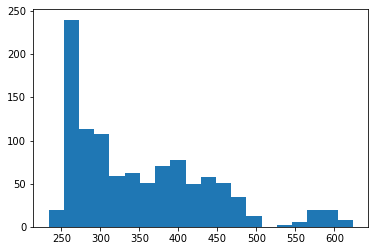

In [25]:
plt.hist(distanceListAll, 20)
plt.show()

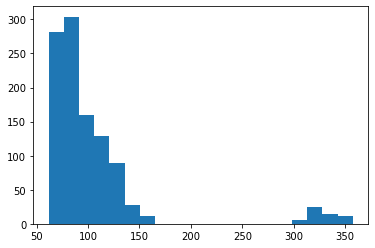

In [26]:
plt.hist(distanceList20, 20)
plt.show()

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList0_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans0 = KMeans(n_clusters = numClusters).fit(x)
kmeans0.cluster_centers_

[0.5096763465870201, 0.5504748689901178, 0.5410957333057352, 0.563497435709759, 0.5864481831007343, 0.5674930803382001, 0.577300968852768, 0.5741767705651505, 0.6040683847415476, 0.5749583334822356, 0.5611461135991792, 0.5678694870868303, 0.567513917972511, 0.5501069357720139, 0.5449577718654225, 0.535677372063539, 0.5332620433733596, 0.5250840316461867, 0.5126581941648654, 0.48869522607411997, 0.5075055715269556, 0.4783939314413954, 0.46619622435432584, 0.48230464594229067, 0.4752679651720458, 0.4697181818849229, 0.458508177652202, 0.44677291369014666, 0.45133126763391995, 0.4409277802058497, 0.43571298509692347, 0.45206613366282034, 0.43900663514135063, 0.4189115183039009, 0.412005964836931, 0.4132128857306539, 0.4371523620838716, 0.42128506137719524, 0.41447966762341476, 0.41831839962165107, 0.4139304435116202, 0.4168987035794482, 0.42610647424413883, 0.4312240390175269, 0.42002717013504987, 0.4037920440715354, 0.41832253975371647, 0.4116201561237979, 0.42179061701942105, 0.41497655

array([[933.84810127, 223.43037975],
       [357.44791667, 509.29166667],
       [486.23232323, 777.45454545],
       [478.61490683, 196.48447205],
       [761.84375   , 301.55      ],
       [284.0375    , 627.025     ],
       [879.50746269, 512.34328358],
       [618.50641026, 675.30128205],
       [285.5       , 221.80555556],
       [553.25974026, 402.07792208]])

In [29]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList1_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans1 = KMeans(n_clusters = numClusters).fit(x)
kmeans1.cluster_centers_

[0.5206153637997896, 0.5373248038716595, 0.5731883141698623, 0.6081411303256593, 0.5743230659175383, 0.5767711277178965, 0.574605958115014, 0.5578860987986288, 0.552757690477951, 0.5241722646538982, 0.5338588754697982, 0.5396938197051586, 0.4870274742044483, 0.48649037199090295, 0.4847616404568739, 0.48423632645241826, 0.48993724127259874, 0.47890692231002197, 0.4663945481481124, 0.46723808650427817, 0.4666941871289918, 0.4648737106381593, 0.46935789119214855, 0.4739369224955439, 0.4598061480396605, 0.4616506662828303, 0.45118955685494744, 0.46213814425078875, 0.4706418835028392, 0.473482745413028, 0.46995274616721605, 0.4660757607208316, 0.4613071008158972, 0.4589277510874675, 0.454622749779838, 0.4373746999089483, 0.43949170757921835, 0.4330018631760789, 0.4418094558702754, 0.4239058853564661, 0.43346926637802696, 0.434013095892262, 0.4089241814776915, 0.4223829874465504, 0.4160010096041696, 0.4205206575711498, 0.4141042709408706, 0.41632361031314463, 0.4092276715588715, 0.4121043643

array([[671.125     , 646.5234375 ],
       [693.98709677, 235.07741935],
       [377.85920578, 335.80144404],
       [914.73825503, 384.80536913],
       [406.41481481, 652.27037037]])

In [30]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList2_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans2 = KMeans(n_clusters = numClusters).fit(x)
kmeans2.cluster_centers_

[0.46417734093592083, 0.5254236052807766, 0.5430977509429425, 0.5437783829425682, 0.5851590092167858, 0.5813052469054227, 0.5600416704549824, 0.5617382210877666, 0.5591376776142345, 0.5491977780278686, 0.5301647113560738, 0.5295330918986175, 0.5162525744303328, 0.5162660895025092, 0.4975747249308657, 0.5026275804852194, 0.4751040014970905, 0.4931457544312516, 0.46337592149231516, 0.4558440089433491, 0.4511931153706565, 0.4476443098244927, 0.4486968805915634, 0.4506261795434164, 0.43489179298291514, 0.43791003214079427, 0.4413845412580994, 0.4245803384762696, 0.4344771877814077, 0.40390386169561787, 0.4087475791010012, 0.3985294958272788, 0.39711121978068187, 0.4034960075324147, 0.396327504287181, 0.39849050640346867, 0.3963228893668675, 0.39573689928618616, 0.39781256416061106, 0.3989576896866616, 0.391138285481277, 0.39335278814828417, 0.3938594947265364, 0.39680974070889463, 0.394319431449455, 0.39512427034394154, 0.39003938101940533, 0.3902540626995578, 0.39225672354498275, 0.384722

array([[540.19230769, 584.40865385],
       [369.38787879, 224.1030303 ],
       [351.30172414, 738.28448276],
       [934.53571429, 143.98214286],
       [781.73170732, 607.93495935],
       [342.07434944, 436.72862454]])

In [31]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList3_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans3 = KMeans(n_clusters = numClusters).fit(x)
kmeans3.cluster_centers_

[0.4454406178490891, 0.48946806078674804, 0.5415620106755925, 0.5023287055199348, 0.5343526309195186, 0.5400943348959706, 0.5419053926055207, 0.5373517484120043, 0.5066730830418116, 0.5057536923110691, 0.523583101165913, 0.5167207229307478, 0.5105391287594505, 0.5030773653074582, 0.500272009553154, 0.4936551048283169, 0.4939268810304565, 0.48233260841064757, 0.46360356750735837, 0.4525451273283228, 0.44049444320050163, 0.43476351949470937, 0.43523003284056216, 0.4323362619755167, 0.42195664199896776, 0.427381331901268, 0.4219885122374468, 0.4110390952330161, 0.40389015206782874, 0.4130726795690546, 0.4078900335296598, 0.4090292903975883, 0.40284419004958333, 0.41342254698896114, 0.40860959616014497, 0.4220369873132391, 0.4097863863202076, 0.39945738543240145, 0.39626770723261034, 0.40256492153505985, 0.4060160949338432, 0.39891288058395946, 0.40569940112747643, 0.41797814244242826, 0.3842335058470602, 0.3836298922284284, 0.4029421554540873, 0.4050814028629993, 0.38744829890179505, 0.39

array([[839.96815287, 445.31847134],
       [599.8343949 , 806.82165605],
       [397.04651163, 571.20930233],
       [592.00549451, 293.51098901],
       [875.09411765, 239.04117647],
       [691.24363636, 477.01454545],
       [362.16071429, 215.78571429]])

In [32]:
len0 = len(pixelCoordList0_sample)
len1 = len(pixelCoordList1_sample)
len2 = len(pixelCoordList2_sample)
len3 = len(pixelCoordList3_sample)

In [33]:
zList0 = [colorGrey0 for i in range(len0)]
zList1 = [colorGrey1 for i in range(len1)]
zList2 = [colorGrey2 for i in range(len2)]
zList3 = [colorGrey3 for i in range(len3)]

In [34]:
# attribute list and coordinate list
zList = zList0 + zList1 + zList2 + zList3
pixelCoordList_sample = pixelCoordList0_sample + pixelCoordList1_sample + pixelCoordList2_sample + pixelCoordList3_sample

In [35]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(223, 980, 107, 864, 485)

In [36]:
def calculateKNeigh(targetCoord, coordList, k = 6): 
    # targetCoord is the coordinate of current point
    # k nearest neighborhood, only consider the k nearest neighbors
    # CoordList is the set of coordinates to compare
    distList = []
    for j in range(len(coordList)):
        dist = distance(targetCoord, coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
#     [distList[ind] for ind in neighIndice]

    return neighIndice

In [37]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [38]:
def mostCommonListHLine(y,xMin, xMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for x in range(xMin, xMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [39]:
def mostCommonListVLine(x,yMin, yMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for y in range(yMin, yMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [40]:
mostCommonListLines = []
for y in range(yMin, yMax + 1, int((yMax + 1 - yMin) / 10)):
    print(y)
    mostCommonList = mostCommonListHLine(y, xMin, xMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

107
182
257
332
407
482
557
632
707
782
857


In [41]:
for x in range(xMin, xMax + 1, int((xMax + 1 - xMin) / 10)):
    print(x)
    mostCommonList = mostCommonListVLine(x, yMin, yMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

223
298
373
448
523
598
673
748
823
898
973


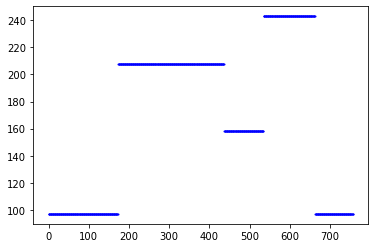

In [42]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [i for i in range(len(mostCommonListLines[0]))]
yList = mostCommonListLines[0]
ax.scatter(xList, yList, s = 1,c = 'blue')

In [43]:
def countSegmentationFun(mostCommonList):
    countSegmentation = 1
    currentValue = mostCommonList[0]
    countDifferentTemp = 0
    for i in range(len(mostCommonList)):
        if mostCommonList[i] ==  currentValue:
            countDifferentTemp = 0
            continue
        else:
            countDifferentTemp += 1
            if countDifferentTemp > 20:
                currentValue = mostCommonList[i]
                countSegmentation += 1
    return countSegmentation

In [44]:
countSegmentationList = []
for mostCommonList in mostCommonListLines:
    countSegmentation = countSegmentationFun(mostCommonList)
    countSegmentationList.append(countSegmentation)
countSegmentationList

[5, 5, 8, 7, 6, 9, 10, 6, 6, 8, 6, 6, 7, 8, 6, 7, 9, 6, 6, 6, 9, 7]

In [45]:
countSegmentation = max(countSegmentationList)
totalNumCluster = countSegmentation**2
numClusterEach = math.ceil(totalNumCluster / 4)
print(numClusterEach)
numCluster0, numCluster1, numCluster2, numCluster3 = numClusterEach,numClusterEach,numClusterEach,numClusterEach

25


In [46]:
kmeans0 = KMeans(n_clusters = numCluster0).fit(pixelCoordList0_sample)
kmeans1 = KMeans(n_clusters = numCluster1).fit(pixelCoordList1_sample)
kmeans2 = KMeans(n_clusters = numCluster2).fit(pixelCoordList2_sample)
kmeans3 = KMeans(n_clusters = numCluster3).fit(pixelCoordList3_sample)

In [47]:
zCenters0 = [colorGrey0 for i in range(kmeans0.cluster_centers_.shape[0])]
zCenters1 = [colorGrey1 for i in range(kmeans1.cluster_centers_.shape[0])]
zCenters2 = [colorGrey2 for i in range(kmeans2.cluster_centers_.shape[0])]
zCenters3 = [colorGrey3 for i in range(kmeans3.cluster_centers_.shape[0])]

In [48]:
coordCenters0 = kmeans0.cluster_centers_.tolist()
coordCenters1 = kmeans1.cluster_centers_.tolist()
coordCenters2 = kmeans2.cluster_centers_.tolist()
coordCenters3 = kmeans3.cluster_centers_.tolist()

In [49]:
zCenters = zCenters0 + zCenters1 + zCenters2 + zCenters3
coordCenters = coordCenters0 + coordCenters1 + coordCenters2 + coordCenters3

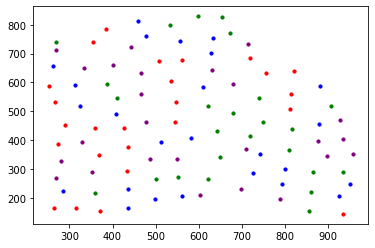

In [50]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in coordCenters0]
yList = [pixelCoord[1] for pixelCoord in coordCenters0]
ax.scatter(xList, yList, s = 10,c = 'blue')

xList = [pixelCoord[0] for pixelCoord in coordCenters1]
yList = [pixelCoord[1] for pixelCoord in coordCenters1]
ax.scatter(xList, yList, s = 10,c = 'purple')

# only focus on the category with largest value
xList = [pixelCoord[0] for pixelCoord in coordCenters2]
yList = [pixelCoord[1] for pixelCoord in coordCenters2]
ax.scatter(xList, yList, s = 10,c = 'red')

xList = [pixelCoord[0] for pixelCoord in coordCenters3]
yList = [pixelCoord[1] for pixelCoord in coordCenters3]
ax.scatter(xList, yList, s = 10,c = 'green')
plt.show()

In [51]:
classHighestValues = coordCenters2 # the third color is with the largest value
X = np.array([[coord[0],coord[1]] for coord in classHighestValues])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
queryResults = kdt.query(X, k=len(classHighestValues), return_distance=True)
distanceArray = queryResults[0]
distanceArray

array([[  0.        ,  65.39189048,  73.4299625 ,  83.797314  ,
        100.53971362, 137.42175723, 163.09601373, 164.47096448,
        190.71246962, 229.94105252, 231.15442209, 243.86273211,
        250.26283396, 273.49471297, 280.91979268, 307.50406944,
        325.29001371, 373.32515526, 397.68710744, 409.94726174,
        410.71446991, 417.26210704, 420.92779135, 465.20889654,
        549.73871916],
       [  0.        ,  64.30909436, 112.32027256, 156.16649422,
        157.21355204, 198.0396496 , 199.20025725, 209.62122969,
        229.02715006, 282.34868287, 347.90549083, 366.8585737 ,
        380.52895975, 417.26210704, 433.98316092, 476.18119369,
        477.1554076 , 484.02084773, 484.20851552, 486.12065274,
        534.11314765, 582.97313998, 633.57655666, 657.41183751,
        690.47626778],
       [  0.        , 385.56686554, 434.3321352 , 504.13794645,
        508.62684955, 521.07582602, 522.39042769, 548.13757451,
        549.73871916, 564.54662652, 582.97313998, 589.4362

In [52]:
import statistics
distanceList = distanceArray.tolist()
distanceList = [statistics.median(distances) for distances in distanceList]
distanceList

[250.2628339602284,
 380.5289597517341,
 602.6916928384144,
 282.13825273856764,
 427.84953310711626,
 434.33213519963874,
 282.13825273856764,
 359.01548346394526,
 278.4076406721704,
 272.5260732583014,
 409.9472617402963,
 280.1529012085285,
 362.3542868313975,
 291.2644782392023,
 280.18899907186074,
 397.68710744416524,
 255.40414764665942,
 300.79756828923354,
 289.4278924217198,
 248.71025122117504,
 265.0660995507279,
 301.17272359465915,
 465.20889654114904,
 424.03063339672076,
 416.23509228817915]

In [53]:
aveMedianDistanceCenters = sum(distanceList)/len(distanceList)
aveMedianDistanceCenters

342.30156788857437

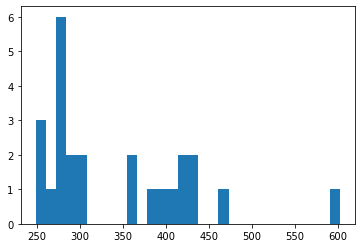

In [54]:
plt.hist(distanceList, 30)
plt.show()

In [55]:
import alphashape

In [56]:
pixelCoordList_sample = pixelCoordList0_sample + pixelCoordList1_sample + pixelCoordList2_sample + pixelCoordList3_sample

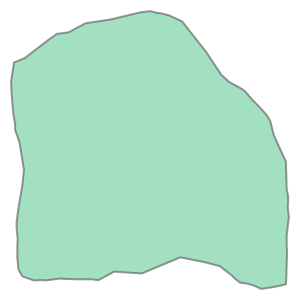

In [57]:
alpha_shape = alphashape.alphashape(pixelCoordList_sample, 0.01) # convex hull
alpha_shape

In [58]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(223, 980, 107, 864, 485)

In [59]:
randomPointListMonteCarlo = []
import random
numMonteCarlo = 10000
numClusterCenters = len(distanceList)
for i in range(numMonteCarlo):
    randomPointList = []
    while len(randomPointList) < numClusterCenters:
        x = random.randint(xMin,xMax )
        y = random.randint(yMin,yMax )
        point = Point(x,y)
        if alpha_shape.contains(point):
            randomPointList.append(point)
    randomPointListMonteCarlo.append(randomPointList)

In [60]:
aveMedianDistanceMonteCarlo = []
for randomPointList in randomPointListMonteCarlo:
    X = np.array([[pixelCoord.x,pixelCoord.y] for pixelCoord in randomPointList])
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    queryResultsAllRandom = kdt.query(X, k=len(distanceList), return_distance=True)
    distanceArrayAllRandom = queryResultsAllRandom[0]
    distanceListAllRandom = distanceArrayAllRandom.tolist()
    distanceListAllRandom = [statistics.median(distanceAllRandom) for distanceAllRandom in distanceListAllRandom]
    aveMedianDistanceRandom = sum(distanceListAllRandom)/len(distanceListAllRandom)
    aveMedianDistanceMonteCarlo.append(aveMedianDistanceRandom)
# distanceListAllRandom

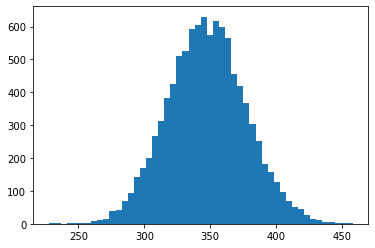

In [ ]:
plt.hist(aveMedianDistanceMonteCarlo, 50)
plt.show()

In [ ]:
aveMedianDistMontArray = np.asarray(aveMedianDistanceMonteCarlo)

In [ ]:
aveMedDistPercentage5 = np.percentile(aveMedianDistMontArray, 5)
aveMedDistPercentage5

In [ ]:
aveMedDistPercentage25 = np.percentile(aveMedianDistMontArray, 2.5)
aveMedDistPercentage25

In [ ]:
if aveMedianDistanceCenters < aveMedDistPercentage25:
    print('concentrated!')
else:
    print('not concentrated...')